#  Objectives of This Notebook

By the end of this notebook, you will be able to:

- Understand the **fundamental concept** and **intuition** behind diffusion models as generative frameworks.
- Learn how the **forward (noising)** and **reverse (denoising)** processes work over multiple time steps.
- Interpret the **mathematical formulation** of diffusion processes using Gaussian noise and probability transitions.
- Describe the **training objective** used to teach the model to reverse noise into structured data.
- Identify and understand the **key components**, such as:
  - Noise schedules (β schedules)
  - Latent variables and time steps
  - Denoising neural networks
- Explore both **advantages** (e.g., training stability, output quality) and **limitations** (e.g., slower sampling) of diffusion models.
- Examine real-world **applications** like image generation, inpainting, super-resolution, and text-to-image models.

- Execute **hands-on code examples** to simulate diffusion and denoising in Python.
- Develop a clear **intuition** for how noise can be learned and reversed using deep learning.

---


# Introduction to Diffusion Models

**Diffusion Models** are a new class of generative models that have shown impressive results in generating high-quality images and other data. Unlike GANs (Generative Adversarial Networks) that learn to generate data through an adversarial process, diffusion models learn to generate data by progressively denoising a random noise signal.

In the **context of representation learning**, diffusion models are learning to represent the underlying data distribution by understanding how information degrades and how it can be restored. This is a powerful way to capture complex data structures.

Imagine you have a clear image, and you gradually add random noise to it until it becomes pure static. A diffusion model learns to reverse this process: starting from static, it incrementally removes noise, step by step, until a clear, meaningful image emerges.

### How Do Diffusion Models Work?

The core idea is:
Diffusion models operate on a simple yet powerful idea:
- **Forward Diffusion Process (Noising)**: Gradually add noise to data until it becomes pure noise.

- **Reverse Diffusion Process (Denoising)**: Learn to reverse this noising process to generate new data.

The **learning** in the reverse process is where the representation learning truly happens. The model implicitly learns how salient features differentiate from noise and how to sequentially refine a noisy input into a coherent data point.


### Historical Context

This approach was first introduced in **2015**  paper called “Deep Unsupervised Learning using Nonequilibrium Thermodynamics and has since formed the foundation of **state-of-the-art** models such as:

- **DALL·E 2**
- **Stable Diffusion**
- **Google's Imagen**

### Why Are Diffusion Models Important?

Compared to earlier generative models (like GANs), diffusion models offer several advantages:

- **More stable training**
- Ability to generate **high-resolution** and **realistic** samples
- Easier to **condition** on additional inputs (e.g., text)


Let’s dive in and explore the fascinating world of diffusion models!


# Working Principle of Diffusion Models

Diffusion models generate data by **learning to reverse a gradual noising process**. The entire framework consists of two main processes:

---

#1.  Forward Diffusion Process (Noising)

The **forward diffusion process** gradually **destroys the structure** in the original data by adding Gaussian noise over multiple time steps until the data becomes indistinguishable from pure noise.
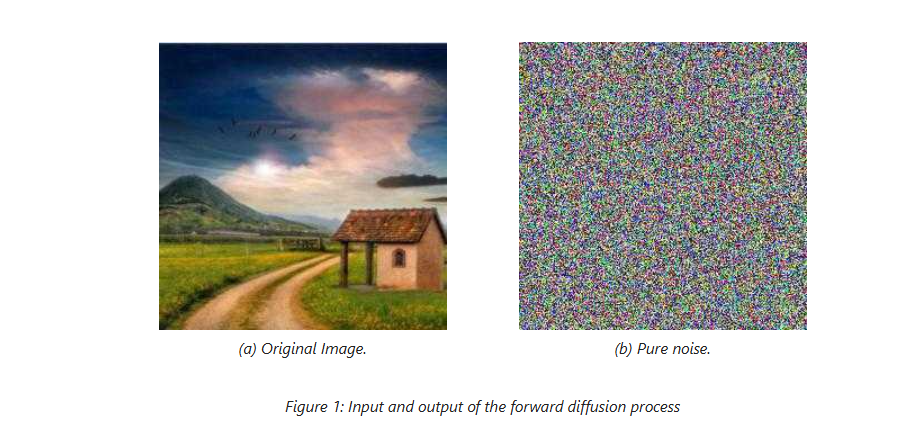



### Intuition:


- Start with a clean image $\mathbf{x}_0$ (Fig. 1a).
- At each time step $t$, add a small amount of noise, progressively degrading the image.
- After many steps, the image looks like pure noise $\mathbf{x}_T$ (Fig. 1b).



### Mathematical Definition:

Each forward step is modeled as a Gaussian transition:
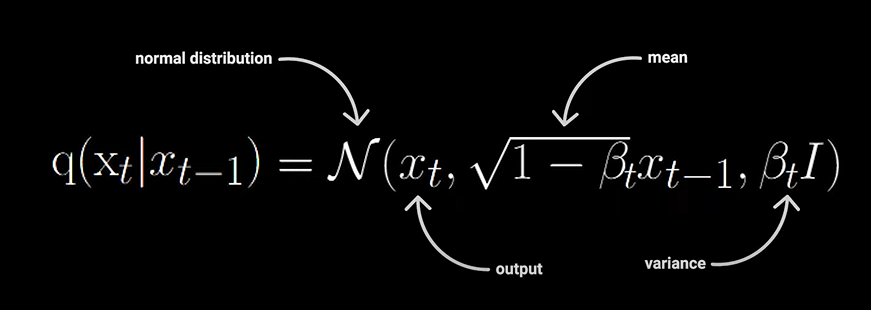


- $\mathbf{x}_t$: Noisy image(output) at step $t$.
- $\beta_t \in (0, 1)$: Variance schedule controlling noise amount at step $t$.
- $\mathcal{N}(\cdot)$: Normal distribution with mean and variance.


### Variance Schedule ($\beta_t$):

- Controls how much noise is added at each step.
- Typically small values (e.g., 0.0001 to 0.02) to avoid exploding variance.
- Common schedules:
  - **Linear schedule**: $\beta_t$ increases linearly with $t$.
  - **Cosine schedule**: More recent improvement, better preserves information early in the process.



### Closed-form for $\mathbf{x}_t$ given $\mathbf{x}_0$:

Instead of computing step-by-step, we can directly sample $\mathbf{x}_t$ from $\mathbf{x}_0$ as:

$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N} \left( \mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, \, \left(1 - \bar{\alpha}_t\right) \mathbf{I} \right)
$$

where:

- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^t \alpha_s$ is the cumulative product of $\alpha$ values up to step $t$.



### Reparameterization Trick:

This allows us to rewrite the noisy sample as:

$$
\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \, \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})
$$

This equation enables **sampling noisy images at any arbitrary step $t$** without sequential simulation.







## 2. Reverse Diffusion Process

The goal of the **reverse diffusion process** is to convert pure noise into a meaningful image. This is accomplished by using a neural network trained to reverse the steps of the forward diffusion process, removing noise incrementally.

If you're familiar with GANs (Generative Adversarial Networks), this is conceptually similar to training a generator network. However, in diffusion models, the generator (our neural network) doesn't generate the image in one shot. Instead, it denoises the image gradually through a sequence of steps.
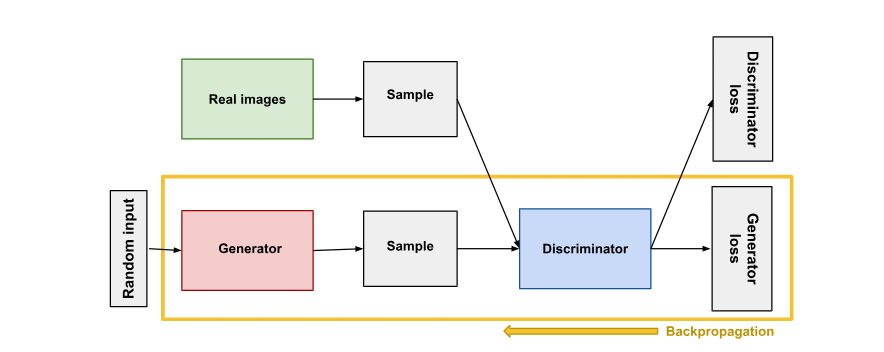

Figure 2: GAN architecture. (source: [Google for Developers](https://developers.google.com/machine-learning/gan/generator))

### Why Not Use GANs?

Training GANs to generate coherent images from noise is notoriously difficult due to stability and convergence issues. Diffusion models solve this by breaking the process into multiple simpler denoising steps. This makes training more stable and allows the model to capture complex data distributions.



### Misconceptions About the Reverse Process

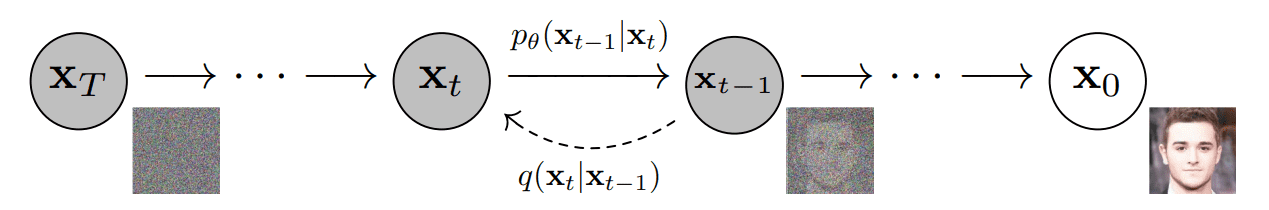
Figure 3 : The directed graphical model. (source:[Deep Unsupervised Learning using Nonequilibrium Thermodynamics, arXiv:1503.03585, 2015.](https://developers.google.com/machine-learning/gan/generator)

It's often misunderstood that the neural network in diffusion models removes noise from an image directly. Instead, it **predicts the noise** to be removed for a specific timestep. For timestep \$t\$, the model predicts the noise that, when removed, should bring us all the way back to the original image (\$t=0\$), not just to \$t-1\$.
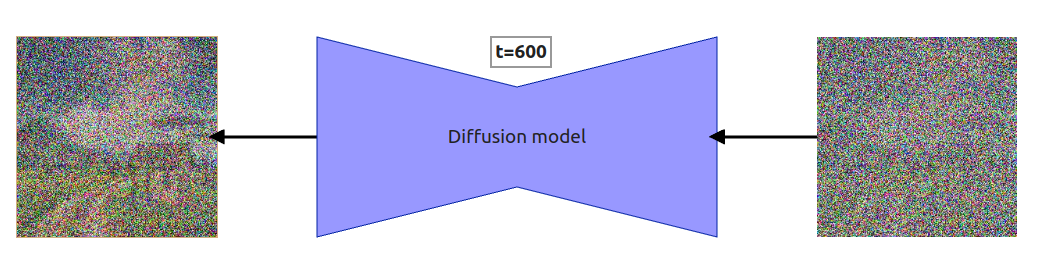

Figure 4: High level visualization of one step from the reverse diffusion process.




### Mathematical Formulation

The reverse process is defined as a Markov chain:

$$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} | x_t)
$$

Each reverse step is modeled as a Gaussian distribution:

$$
p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \Sigma_\theta(x_t, t))
$$

The variance term is often fixed as:

$$
\Sigma_\theta(x_t, t) = \beta_t I
$$

The mean \$\mu\_\theta(x\_t, t)\$ is computed as:

$$
\mu_\theta(x_t, t) = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t)\right)
$$

Thus, we can sample \$x\_{t-1}\$ using:

$$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left(x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t)\right) + \sqrt{\beta_t} \cdot \epsilon
$$

Where:

* \$\epsilon\_\theta(x\_t, t)\$ is the predicted noise by the model.
* \$\epsilon \sim \mathcal{N}(0, I)\$ is standard Gaussian noise.



### Final Step (No Noise Added)

At the final step (\$t=1\$), noise is **not added** to \$x\_0\$. This is because we are expected to have denoised the sample as much as possible.



### Visual Understanding

In each reverse step:

* Input: \$x\_t\$ (a noisy version of the image)
* Model predicts: \$\epsilon\_\theta(x\_t, t)\$
* Compute: \$x\_{t-1}\$ by subtracting predicted noise

The process is repeated from \$t=T\$ to \$t=1\$.


### Interesting Observation: Full Noise Removal

An insightful experiment is to subtract the full predicted noise from the image at each step, without feeding the result into the next step. This shows that even at early timesteps, the model’s predictions resemble the final image to some extent.

This suggests two optimizations:

1. **Use fewer timesteps during inference** (as good noise predictions make larger jumps possible).
2. **Use a different schedule for inference** (e.g., cosine instead of linear).

---

By breaking the generative process into a series of tractable denoising steps, diffusion models offer a powerful and stable alternative to GANs for image generation.


## Reverse diffusion output visualization
Before we get into architecture, I want to show you one thing that was very interesting to me (and might be for you). As described previously, each time we predict the noise using a neural network, we subtract part of it and move to the next step. That is how the diffusion process works. But what will happen if we just subtract all the noise? I’ve generated an example of such subtraction for every timestep (<1,50> with a linear schedule).

**Notice!**  
Because this is a reverse process, when we say \( t = 1 \), the value of \( \beta_t \) is set to:

$$
\beta_t = \beta_{T - t + 1}
$$

Where \( T \) is the total number of diffusion steps.

For example:

- When \( t = 1 \), we use:  
  $$
  \beta_1 = \beta_{T}
  $$

- When \( t = 2 \), we use:  
  $$
  \beta_2 = \beta_{T - 1}
  $$

- And so on...
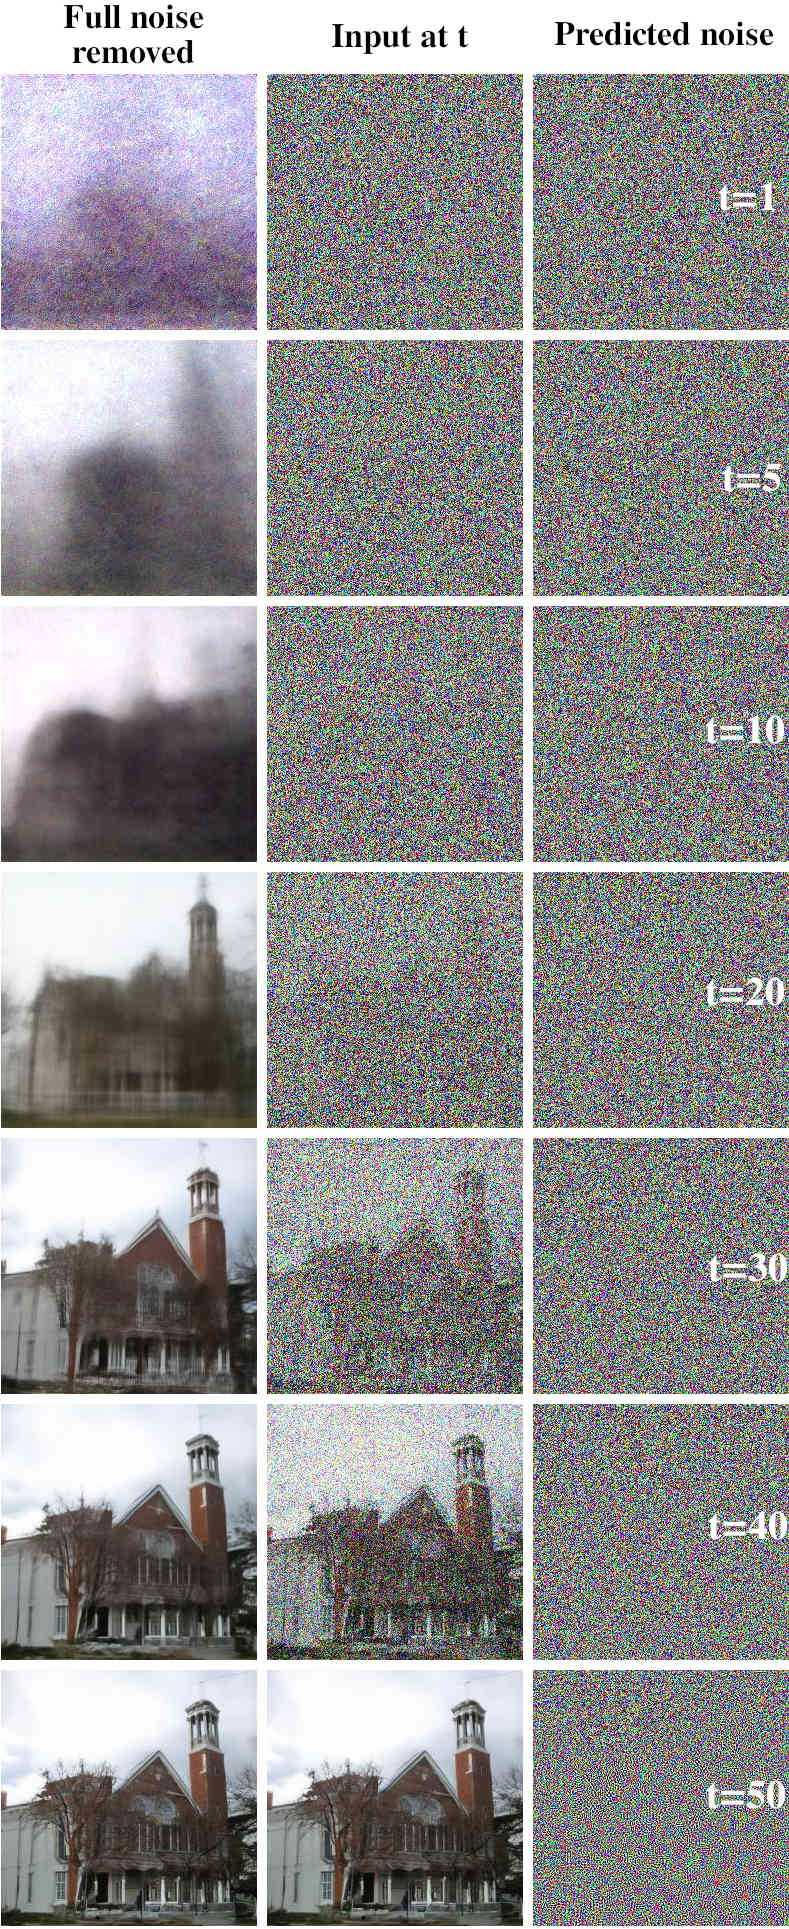
Figure 5: Result of full noise removal

### References

- Piro, K. (2022, September 4). *Step-by-step visual introduction to diffusion models*. Medium. [https://medium.com/@kemalpiro/step-by-step-visual-introduction-to-diffusion-models-235942d2f15c](https://medium.com/@kemalpiro/step-by-step-visual-introduction-to-diffusion-models-235942d2f15c)
